In [41]:
import os
import json
import time
from openai import OpenAI
from random import seed, shuffle
from collections import Counter
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from datasets import load_dataset
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from GET_API_KEY import GET_OPENAI_API_KEY

In [25]:
gpt4_name = 'gpt-4-0613'
temperature = 0.0
openai_api_key = GET_OPENAI_API_KEY()
gpt4 = ChatOpenAI(model_name=gpt4_name, temperature=temperature,
                    openai_api_key=openai_api_key, request_timeout=120)

client = OpenAI(
    api_key = openai_api_key,
)

In [26]:
def compute_embedding(model_name,_input):
    response = client.embeddings.create(
    model=model_name,
    input=_input
    )
    return response.data[0].embedding

In [6]:
dataset = load_dataset("allenai/c4", "realnewslike")

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Using the latest cached version of the dataset since allenai/c4 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'realnewslike' at /home/ShenChenchen/.cache/huggingface/datasets/allenai___c4/realnewslike/0.0.0/1588ec454efa1a09f29cd18ddd04fe05fc8653a2 (last modified on Tue Mar 26 12:00:09 2024).


Loading dataset shards:   0%|          | 0/76 [00:00<?, ?it/s]

In [31]:
batch_size = 10
epoch = 30
paraphrase_prompt_string = "You need to be an expert in linguistics. I will give you a paragraph as input, and you need to paraphrase this input. You should keep the original meaning while making substitution to the sentence's structure and words. [INPUT]{input} [OUTPUT]"
paraphrase_prompt = ChatPromptTemplate.from_template(paraphrase_prompt_string)
original_text_list = dataset['validation']['text'][:epoch]
_input_list = []

for text in original_text_list:
    _input_list.append(paraphrase_prompt.format_messages(input = text))


_output_list = []
for batch_id in tqdm(range(0, len(_input_list), batch_size), desc="Paraphrasing"):
    _input_batch = _input_list[batch_id:batch_id + batch_size]
    _outputs = [out.content for out in gpt4.batch(_input_batch)]
    _output_list.extend(_outputs)


Paraphrasing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:20<00:00, 46.97s/it]


In [32]:
_embedding_list = []

for _input in _output_list:
    _embedding_list.append(compute_embedding(model_name='text-embedding-3-small', _input = _input))

In [37]:
original_text_embedding_list = []
for _input in original_text_list:
    original_text_embedding_list.append(compute_embedding(model_name='text-embedding-3-small', _input = _input))

In [45]:
irrelevant_list_1 = dataset['validation']['text'][epoch*10: epoch*11]
irrelevant_list_2 = dataset['validation']['text'][epoch*20: epoch*21]
irrelevant_embedding_list_1 = []
irrelevant_embedding_list_2 = []
for _input in irrelevant_list_1:
    irrelevant_embedding_list_1.append(compute_embedding(model_name='text-embedding-3-small', _input = _input))
for _input in irrelevant_list_2:
    irrelevant_embedding_list_2.append(compute_embedding(model_name='text-embedding-3-small', _input = _input))

In [46]:
def embedding_similarity_calc(original_text_embedding_list, paraphrased_text_embedding_list):
    assert len(original_text_embedding_list) == len(paraphrased_text_embedding_list), "Two datasets have different length"
    similarity_list = []
    two_norm_list = []
    for i in range(len(original_text_embedding_list)):
        vector_a = np.array(original_text_embedding_list[i])
        vector_b = np.array(paraphrased_text_embedding_list[i])
        two_norm_list.append(np.linalg.norm(vector_a - vector_b))
        similarity_list.append(np.dot(vector_a, vector_b) / (np.linalg.norm(vector_a) * np.linalg.norm(vector_b)))
    return two_norm_list, similarity_list

norm, similarity = embedding_similarity_calc(original_text_embedding_list, _embedding_list)
norm_contrast, similarity_contrast = embedding_similarity_calc(irrelevant_embedding_list_1, irrelevant_embedding_list_2)

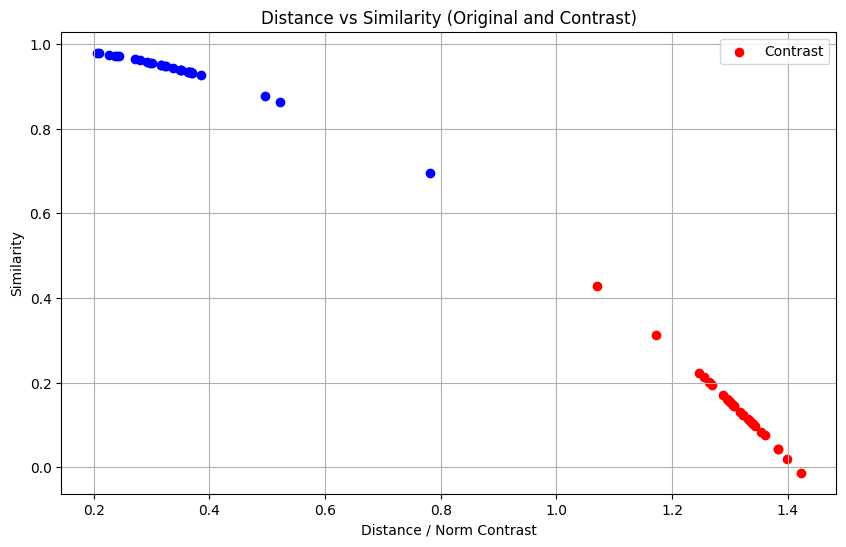

In [47]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.scatter(norm, similarity, color='blue')  # Plot distances vs similarities
plt.scatter(norm_contrast, similarity_contrast, color='red', label='Contrast')  # Plot norm_contrast vs similarity_contrast

# Adding titles and labels
plt.title('Distance vs Similarity (Original and Contrast)')
plt.xlabel('Distance / Norm Contrast')
plt.ylabel('Similarity')

# Show legend to distinguish between datasets
plt.legend()

# Show grid for easier interpretation
plt.grid(True)

# Display the plot
plt.show()

In [18]:
len(_output_list)
print(_output_list[0])
print("="*100)
print(dataset['validation']['text'][0])

The cluster includes IBM's eServer 325 server, which is based on Opteron, along with systems management software and storage devices that are compatible with both Linux and Windows operating systems. IBM announced on Tuesday a preassembled and pretested cluster powered by Advanced Micro Devices Inc.'s 64-bit Opteron processor. IBM, located in Armonk, N.Y., is merging its Opteron-based eServer 325 server, aimed at scientific and technical computing users, with systems management software and storage devices to provide a comprehensive package that supports Linux and Windows operating systems. This new product, which will be available later this month or in early December, is a part of IBM's eServer Cluster 1350, which also includes bundles based on the company's BladeCenter blade servers and dual-processor x335 and x345 systems using Intel Corp.'s 32-bit Xeon chips. Clusters are made up of multiple servers connected together to create a supercomputing environment for users. In a related 